In [1]:
#from f3dasm import ExperimentData
import numpy as np
from pathlib import Path
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects
from matplotlib import cm # to change colors of surface plots
import matplotlib.pyplot as plt # import plotting tools to create figures

# NN Libraries
from tensorflow import keras # fast library for ANNs
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers import Dense # to create a feedforward neural network with dense layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score, mean_squared_error



In [2]:
# Function defining our Artificial Neural Network.
def create_ANN(input_dimensions=1, # number of input variables
               neurons1=3, # number of neurons in first hidden layer
               neurons2=2, # number of neurons in second hidden layer
               activation='relu', # activation function
               optimizer='adam', # optimization algorithm to compute the weights and biases
               output_dimensions=1,
               output_activation='linear'): # number of output variables
    # create model
    model = Sequential() # Feedforward architecture
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(output_dimensions, activation=output_activation)) # output layer using Linear activation function because
                                                             # we are doing regression (we could also ommit the
                                                             # activation='linear' command because keras
                                                             # would pick the right activation function
                                                             # when we ask for the correct loss below)
    model.compile(loss='mse', # our NLL (loss or error function)
                  optimizer=optimizer)
    return model

In [3]:
# Loading the data
domain_3 = pd.read_pickle("data/supercompressible_3d_domain.pkl")
input_3 = pd.read_csv("data/supercompressible_3d_input.csv", index_col=0)
jobs_3 = pd.read_pickle("data/supercompressible_3d_jobs.pkl")
output_3 = pd.read_csv("data/supercompressible_3d_output.csv", index_col=0)

domain_7 = pd.read_pickle("data/supercompressible_7d_domain.pkl")
input_7 = pd.read_csv("data/supercompressible_7d_input.csv", index_col=0)
jobs_7 = pd.read_pickle("data/supercompressible_7d_jobs.pkl")
output_7 = pd.read_csv("data/supercompressible_7d_output.csv", index_col=0)

2023-12-07 15:20:55,319 - f3dasm - INFO - Imported f3dasm (version: 1.4.3)


## 3D: Classification

In [4]:
# Generating scaled data for classification (3d)
testset_ratio = 0.25
SEED = 123
DIM = 3  # Adjust to run for binary classification instead of 3 class (combines coilable)
INPUT_DIM = 3  # Adjust to run for the 3 or 7 variable dataset

# Deciding on input dataset
if INPUT_DIM == 3:
    output = output_3
else:
    output = output_7

# Adjusting Output Dim Classes (if necessary)
if DIM == 2:
    output_3.coilable = output_3.coilable.astype(bool).astype(int)
X_train, X_test, y_train, y_test = train_test_split(input_3, output_3["coilable"].values, test_size=testset_ratio, random_state=SEED)

# Class-dimensional y train and test
Y_train = np.zeros([len(y_train), 3])
for i in range(len(y_train)):
    Y_train[i][y_train[i]] = 1
    
Y_test = np.zeros([len(y_test), 3])
for i in range(len(y_test)):
    Y_test[i][y_test[i]] = 1

# Scaling (standard)
scaler = StandardScaler().fit(X_train) 
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [5]:
# ANN Pareameters
neurons1=64 # number of neurons for the first hidden layer
neurons2=32 # number of neurons for the second hidden layer
activation='relu' # choose activation function
batch_size = 2500 # considering the entire dataset for updating the weights and biases in each epoch
epochs = 500  # number of times we train the neural network with the entire training set
optimizer = Adam(learning_rate=0.001) 
ANN_model = KerasRegressor(model=create_ANN, input_dimensions=len(X_train.columns), neurons1=neurons1, neurons2=neurons2,
                           activation=activation, batch_size=batch_size, epochs=epochs,
                           optimizer=optimizer, output_dimensions=3, output_activation='sigmoid')

In [6]:
# Running model
history = ANN_model.fit(X_train_scaled, Y_train, validation_data=(X_test_scaled, Y_test))

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.2541 - val_loss: 0.2520
Epoch 2/500
1/1 [==============================] - 0s 145ms/step - loss: 0.2499 - val_loss: 0.2479
Epoch 3/500
1/1 [==============================] - 0s 101ms/step - loss: 0.2458 - val_loss: 0.2439
Epoch 4/500
1/1 [==============================] - 0s 100ms/step - loss: 0.2418 - val_loss: 0.2401
Epoch 5/500
1/1 [==============================] - 0s 76ms/step - loss: 0.2379 - val_loss: 0.2364
Epoch 6/500
1/1 [==============================] - 0s 85ms/step - loss: 0.2342 - val_loss: 0.2328
Epoch 7/500
1/1 [==============================] - 0s 94ms/step - loss: 0.2306 - val_loss: 0.2294
Epoch 8/500
1/1 [==============================] - 0s 94ms/step - loss: 0.2272 - val_loss: 0.2260
Epoch 9/500
1/1 [==============================] - 0s 75ms/step - loss: 0.2238 - val_loss: 0.2228
Epoch 10/500
1/1 [==============================] - 0s 106ms/step - loss: 0.2205 - val_loss: 0.2196
Epoch 11/500
1/1 

In [7]:
# Cleaning Predicions for y
y_pred = history.model_.predict(X_test_scaled) # predict all data points with ANN
yp = []
for yps in y_pred:
    yp.append(np.argmax(yps))
    
yp = np.array(yp)

8/8 [==============================] - 0s 4ms/step


In [8]:
# Generating matrix and accuracy metrics
con_matrix = confusion_matrix(y_test,yp)
ac = accuracy_score(y_test, yp)
pr = precision_score(y_test, yp, average=None)
rc = recall_score(y_test, yp, average=None)
f1 = f1_score(y_test, yp, average=None)

print(con_matrix)
print(ac)
print(pr)
print(rc)
print(f1)

[[ 70   6   2]
 [  3  32  18]
 [  5  12 102]]
0.816
[0.8974359  0.64       0.83606557]
[0.8974359  0.60377358 0.85714286]
[0.8974359  0.62135922 0.84647303]


2/2 [==============================] - 0s 0s/step


Text(0.5, 1.0, 'ANN Categorical with ratio_top_diameter')

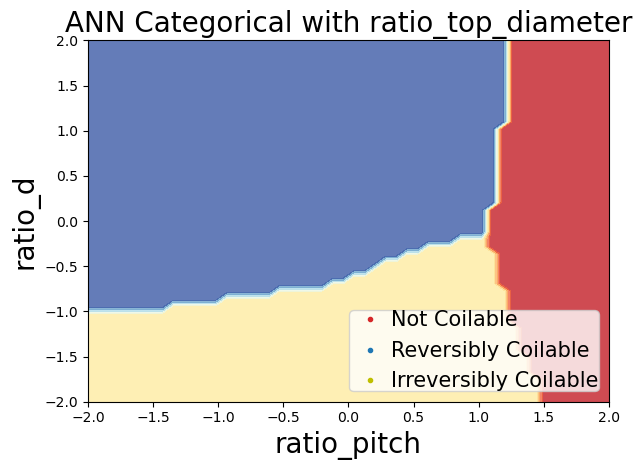

In [9]:
# Plotting Classification NN Decision Boundary on chosen ratio_top_diameter point (index=249)
if INPUT_DIM != 3:
    print("Warning: Can only generate this plot on the 3d dataset")
    raise Exception("Input dim must be three for this plot to work")

# Plot Inputs
plt_title = "ANN Categorical with ratio_top_diameter"
n_classes = DIM
plot_colors = 'ryb' # defining the colors for each category (yellow is ignored if n_classes == 2)

# Generating grid to plot upon
RES = 50
X1_data_space = np.linspace(-2, 2, RES)
X2_data_space = np.linspace(-2, 2, RES)
X3 = X_train_scaled[249][2]
xv, yv = np.meshgrid(X1_data_space, X2_data_space)

# Filling predictions
Z = np.zeros([RES, RES])
for j in range(RES):
    inp_col = [[X1_data_space[i], X2_data_space[j], X3] for i in range(RES)]
    Z[:, j] = np.argmax(history.model_.predict(inp_col), axis=1)
    
# Plotting
fig2, ax2 = plt.subplots(tight_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax2.contourf(xv, yv, Z, cmap=cm.RdYlBu, alpha=0.8)

# Labels and legend
ax2.set_ylabel('ratio_d', fontsize=20)
ax2.set_xlabel('ratio_pitch', fontsize=20)
plt.plot([], [], ".", color="C3", label="Not Coilable")
if n_classes == 2:
    plt.plot([], [], ".", color="C0", label="Coilable")
if n_classes == 3:
    plt.plot([], [], ".", color="C0", label="Reversibly Coilable")
    plt.plot([], [], ".", color="y", label="Irreversibly Coilable")
    
ax2.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
ax2.set_title(plt_title, fontsize=20)


## Regression (Flexible to 3D & 7D Datasets)

In [10]:
# Categorical works. Let's try regression
testset_ratio = 0.25
SEED = 123
np.random.seed(SEED)

DS = 3  # Option to switch input variable here as well
if DS == 3:
    ip = input_3
    op = output_3
else:
    ip = input_7
    op = output_7

# Sticking to general strategy of dropping any input data with 
# Note that this will result in different scalar than before
clean_idx = op.dropna().index
X_train, X_test, y_train, y_test = train_test_split(ip.iloc[clean_idx], op.iloc[clean_idx][["sigma_crit", "energy"]].values, test_size=testset_ratio, random_state=SEED)

# Generating X & Y Scaled Data
scaler = StandardScaler().fit(X_train) 
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scaled=scaler_y.transform(y_train)
y_test_scaled=scaler_y.transform(y_test)

# Generating model
neurons1 = 64 # number of neurons for the first hidden layer
neurons2 = 32 # number of neurons for the second hidden layer
activation = 'relu' # choose activation function
batch_size = 200 # considering the entire dataset for updating the weights and biases in each epoch
epochs = 1000 # number of times we train the neural network with the entire training set
optimizer = Adam(learning_rate=0.001) # specifying the learning rate value for the optimizer (PLAY WITH THIS!)
ANN_model = KerasRegressor(model=create_ANN, input_dimensions=len(X_train.columns), neurons1=neurons1, neurons2=neurons2,
                           activation=activation, batch_size=batch_size, epochs=epochs,
                           optimizer=optimizer, output_dimensions=2)

In [11]:
# Running Regression Model
history = ANN_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/1000
2/2 [==============================] - 2s 516ms/step - loss: 1.0494 - val_loss: 0.9050
Epoch 2/1000
2/2 [==============================] - 0s 125ms/step - loss: 0.9862 - val_loss: 0.8483
Epoch 3/1000
2/2 [==============================] - 0s 84ms/step - loss: 0.9310 - val_loss: 0.7960
Epoch 4/1000
2/2 [==============================] - 0s 82ms/step - loss: 0.8770 - val_loss: 0.7475
Epoch 5/1000
2/2 [==============================] - 0s 106ms/step - loss: 0.8279 - val_loss: 0.7027
Epoch 6/1000
2/2 [==============================] - 0s 87ms/step - loss: 0.7810 - val_loss: 0.6610
Epoch 7/1000
2/2 [==============================] - 0s 73ms/step - loss: 0.7392 - val_loss: 0.6214
Epoch 8/1000
2/2 [==============================] - 0s 88ms/step - loss: 0.6972 - val_loss: 0.5836
Epoch 9/1000
2/2 [==============================] - 0s 70ms/step - loss: 0.6584 - val_loss: 0.5476
Epoch 10/1000
2/2 [==============================] - 0s 84ms/step - loss: 0.6213 - val_loss: 0.5132
Epoch 

In [12]:
# Predicting Test Values
y_pred_scaled = history.model_.predict(X_test_scaled) 
y_pred = scaler_y.inverse_transform(y_pred_scaled)

5/5 [==============================] - 0s 6ms/step


In [13]:
# Generating Metrics (scaled and unscaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_unscaled = r2_score(y_test, y_pred)
mse_unscaled = mean_squared_error(y_test,y_pred)
print(r2, r2_unscaled)  # These are the same
print(mse, mse_unscaled)  # These are not

0.9986632620152653 0.9986632635005089
0.0012329944202830157 0.3305869133551952
